# Forecasting the total sales 

In [1]:
import os 
import sys

# Get the absolute path of the project root 

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))

# Adding project root in syspath
sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import reduce_mem_usage

import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
# Load and reducing the memeory usage from the data
df_train = reduce_mem_usage(pd.read_csv('../../data/processed/train_final.csv'))
df_test = reduce_mem_usage(pd.read_csv('../../data/processed/test_final.csv'))

df_calendar_event = pd.read_csv('../../data/raw/calendar_events.csv')

Memory usage of dataframe is 2507.65 MB
Memory usage after optimization is: 846.33 MB
Decreased by 66.2%
Memory usage of dataframe is 1077.03 MB
Memory usage after optimization is: 363.50 MB
Decreased by 66.2%


Combining the year, month and day column to get the date column.

In [3]:
# Convert year, month, day to a date column
df_train['date'] = pd.to_datetime(df_train[['year', 'month', 'day']])
df_test['date'] = pd.to_datetime(df_test[['year', 'month', 'day']])


In [4]:
# making copy of train and test data
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [5]:
# renaming the date and total sales to ds and y format as expected in prophet

df_train_copy.rename(columns={'date': 'ds', 'total_sales':'y'}, inplace=True)
df_test_copy.rename(columns={'date':'ds', 'total_sales':'y'}, inplace=True)

In [6]:
# extracting only date stamp and values
# for both train and test data

df_train_copy = df_train_copy[['ds','y']]
df_test_copy = df_test_copy[['ds','y']]

In [7]:
# goruping the data as total sales per day in a particular datestamp
grouped_train_data = df_train_copy.groupby('ds')['y'].sum().reset_index()
grouped_test_data = df_test_copy.groupby('ds')['y'].sum().reset_index()


In [8]:
# displaying the entries of the train data
grouped_train_data.head()

,ds,y
0,2011-01-29,81649.953125
1,2011-01-30,78969.398438
2,2011-01-31,57706.687500
3,2011-02-01,60760.929688
4,2011-02-02,46959.585938


## Data Exploration and Visualization 

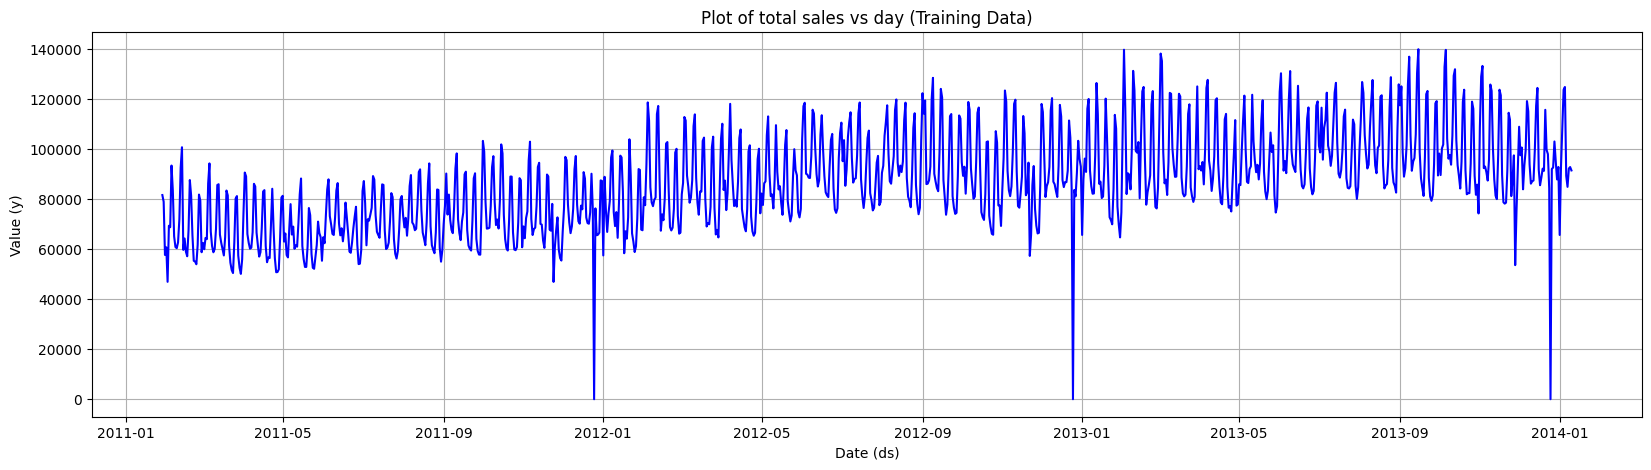

In [9]:
## ploting the total sales against the datestamp for training data

# Plotting
plt.figure(figsize=(20,5))
plt.plot(grouped_train_data['ds'], grouped_train_data['y'], linestyle='-', color='b')

# Add labels and title
plt.xlabel('Date (ds)')
plt.ylabel('Value (y)')
plt.title('Plot of total sales vs day (Training Data)')
plt.grid(True)

# Show the plot
plt.show()

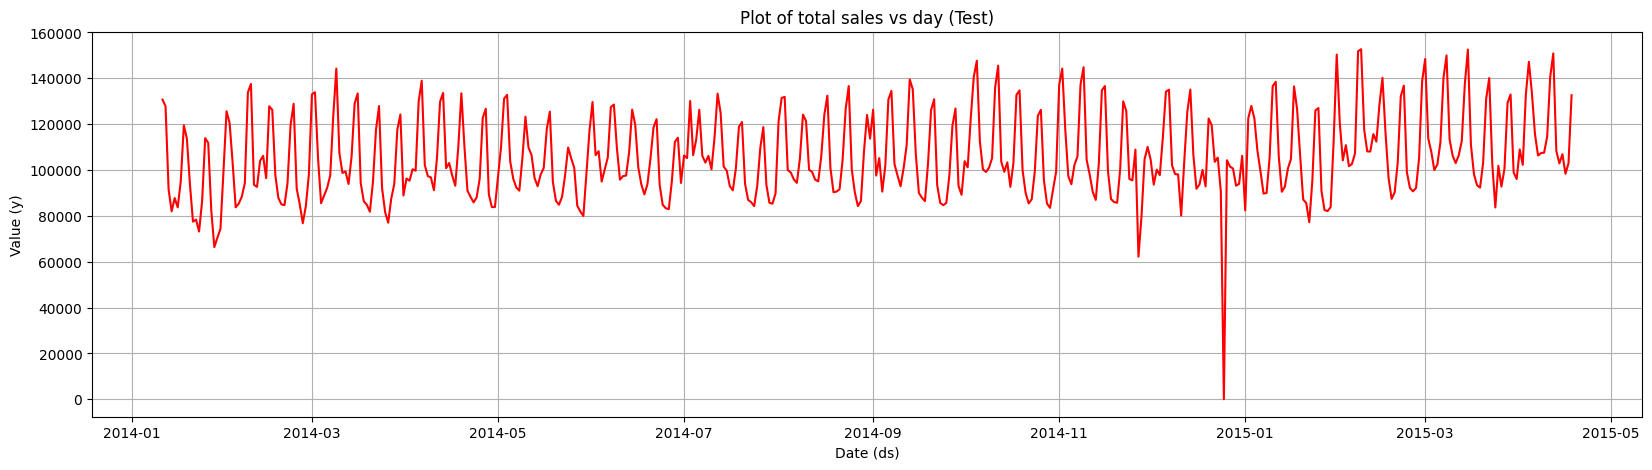

In [10]:

# Plotting
plt.figure(figsize=(20,5))
plt.plot(grouped_test_data['ds'], grouped_test_data['y'], linestyle='-', color='r')

# Add labels and title
plt.xlabel('Date (ds)')
plt.ylabel('Value (y)')
plt.title('Plot of total sales vs day (Test)')
plt.grid(True)

# Show the plot
plt.show()

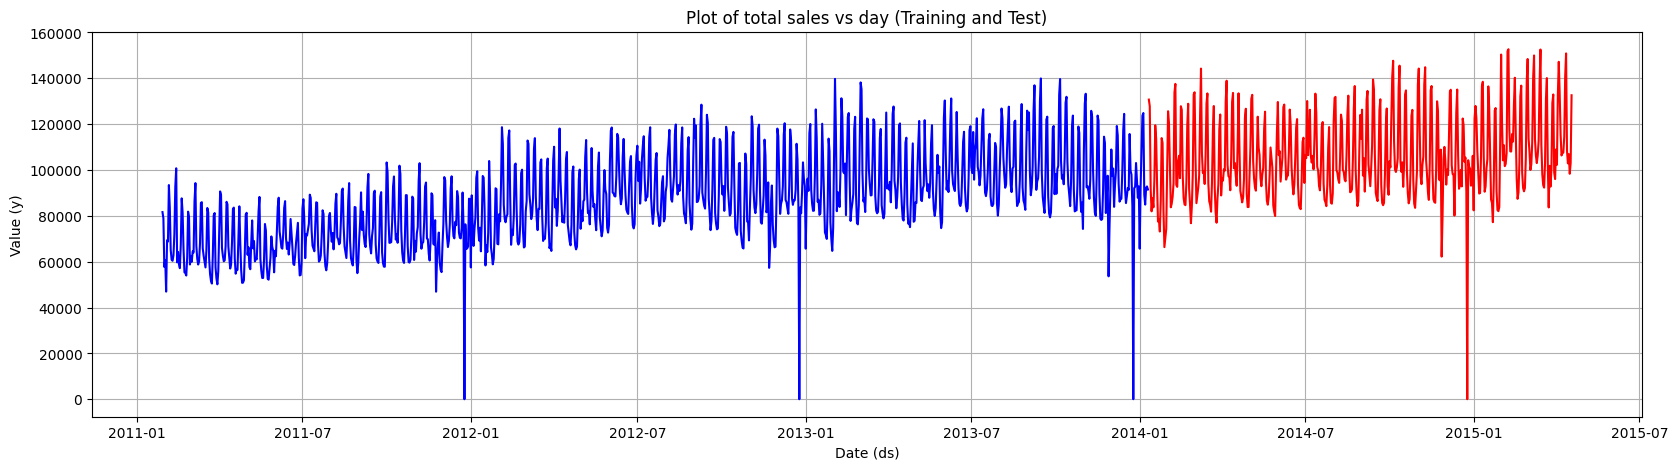

In [11]:
## ploting the total sales against the datestamp for training data

# Plotting
plt.figure(figsize=(20,5))
plt.plot(grouped_test_data['ds'], grouped_test_data['y'], linestyle='-', color='r')
plt.plot(grouped_train_data['ds'], grouped_train_data['y'], linestyle='-', color='b')

# Add labels and title
plt.xlabel('Date (ds)')
plt.ylabel('Value (y)')
plt.title('Plot of total sales vs day (Training and Test)')
plt.grid(True)

# Show the plot
plt.show()

# Modeling and Evaluation

### Baseline Model 

To develop a baseline model for forecasting Prophet with its default parameters is used.

In [12]:
from src.models.model import NullRegressor

# baseline model as Null Regressor
base_model = NullRegressor()

y_base = base_model.fit_predict(grouped_train_data['y'])

In [13]:
from src.models.evaluation_metric import print_regressor_scores

print_regressor_scores(y_base, grouped_train_data['y'], set_name='Training')

RMSE Training: 19157.7109375
MAE Training : 15062.69140625
R2 score Training : 0.0


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [14]:
print_regressor_scores( grouped_test_data['y'], base_model.predict(grouped_test_data['y']), set_name='Test set')

RMSE Test set: 26544.859375
MAE Test set : 20590.568359375
R2 score Test set : -1.0785386562347412


Remarks:
- RMSE score and MAE of baseline model is very high and during testing the baseline model has performed even worst.

# 1) Prophet with default parameter

In [15]:
import numpy as np
np.float_ = np.float64
from prophet import Prophet

prophet_model = Prophet()

# training on the train data
prophet_model.fit(grouped_train_data)

# making forecast on the test data 
forecast = prophet_model.predict(grouped_test_data)

Importing plotly failed. Interactive plots will not work.
15:05:01 - cmdstanpy - INFO - Chain [1] start processing
15:05:01 - cmdstanpy - INFO - Chain [1] done processing


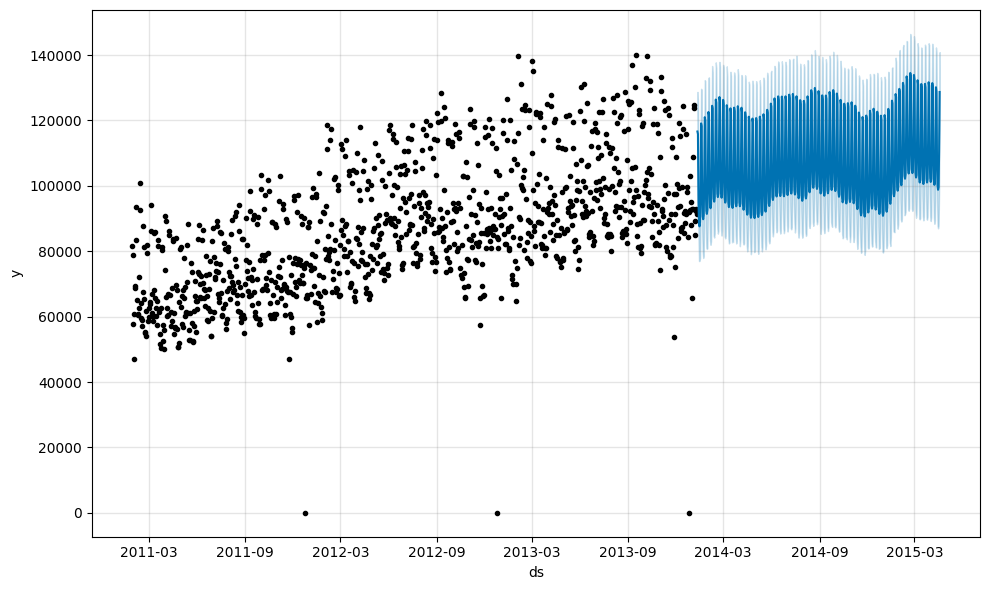

In [16]:
# plotting the forecast to evaluate the model visually

prophet_model.plot(forecast)
plt.show()

Remarks:
- The baseline model performed pretty well with its default parameters capturing the increasing trend of sales.
- However the uncertainty region is wider indicating more unicertainty in the future. 
- No any visible seasonality cycle is observed. 

Lets fine tune the model performance introducing the hyperparameters.

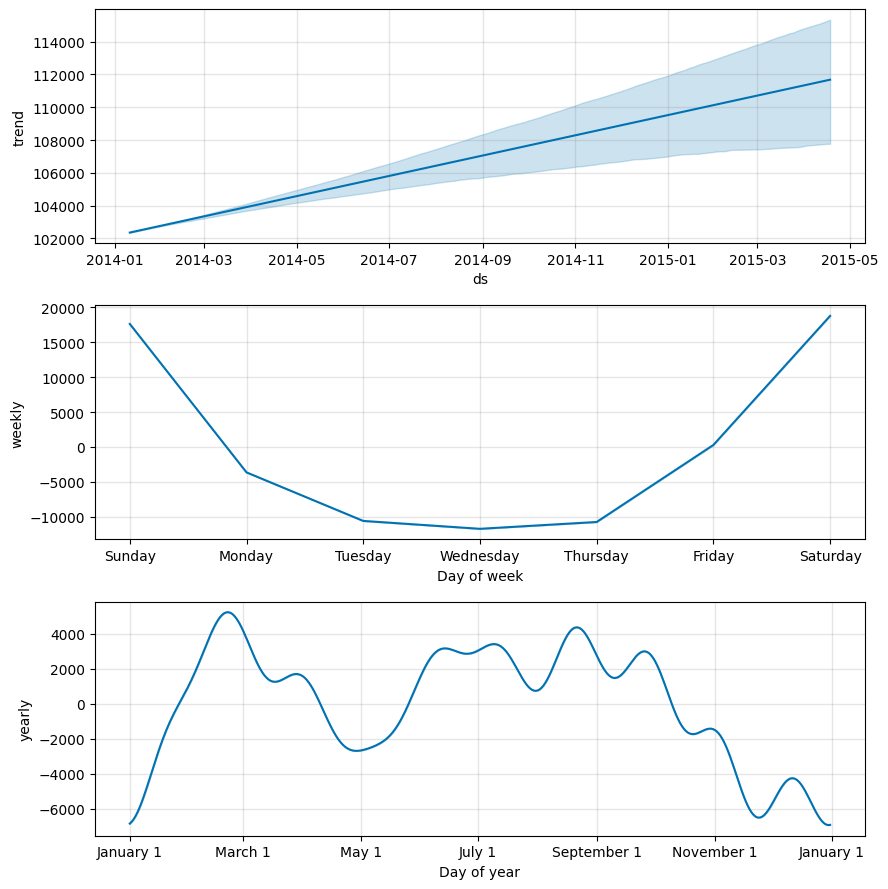

In [17]:
# Plot forecast components (trend, yearly, weekly seasonality)
prophet_model.plot_components(forecast)
plt.show()

Remarks:
- The confidence intervals of forecast which is the uncertainity band shows increasing trend with the forecast made over the time.
- This indicates that the model will forecast poorly in near future..

In [18]:
# Evaluating the model performance on train and test data

print_regressor_scores( grouped_test_data['y'], forecast['yhat'], set_name="Train data")
print("--------"*100)
print_regressor_scores( grouped_test_data['y'], forecast['yhat'], set_name="Test data")

RMSE Train data: 10319.432777808486
MAE Train data : 7748.262175644016
R2 score Train data : 0.6858703486146825
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
RMSE Test data: 10319.432777808486
MAE Test data : 7748.262175644016
R2 score Test data

The RMSE and MAE score is very less compared to baseline model.

### Cross Validation 

In [19]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric


cv_results = cross_validation(prophet_model, initial='730 days', period='7 days', horizon='7 days')

  0%|          | 0/49 [00:00<?, ?it/s]15:05:02 - cmdstanpy - INFO - Chain [1] start processing
15:05:02 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/49 [00:00<00:09,  5.14it/s]15:05:02 - cmdstanpy - INFO - Chain [1] start processing
15:05:02 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 2/49 [00:00<00:09,  4.82it/s]15:05:02 - cmdstanpy - INFO - Chain [1] start processing
15:05:02 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 3/49 [00:00<00:11,  4.16it/s]15:05:02 - cmdstanpy - INFO - Chain [1] start processing
15:05:02 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 4/49 [00:00<00:10,  4.37it/s]15:05:03 - cmdstanpy - INFO - Chain [1] start processing
15:05:03 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 5/49 [00:01<00:09,  4.62it/s]15:05:03 - cmdstanpy - INFO - Chain [1] start processing
15:05:03 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 6/49 [00:01<00:09,  4.66it/s]15:05:03

In [20]:
metrics_results = performance_metrics(cv_results)

metrics_results

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,7.964860e+07,8924.606531,6691.088746,0.056021,0.049821,0.056489,0.836735
1,2 days,1.124381e+08,10603.683469,8426.500616,0.070581,0.054851,0.071372,0.673469
2,3 days,6.251587e+07,7906.697719,6395.897592,0.067394,0.057960,0.066975,0.857143
3,4 days,4.811726e+07,6936.660697,5955.959372,0.068200,0.066808,0.067503,0.897959
4,5 days,2.227621e+08,14925.217916,8054.548541,52.050420,0.075683,0.112472,0.836735
5,6 days,6.870530e+07,8288.866298,6561.606068,0.081294,0.066835,0.076978,0.857143
6,7 days,4.736715e+07,6882.380006,5508.782785,0.057003,0.046440,0.055942,0.897959


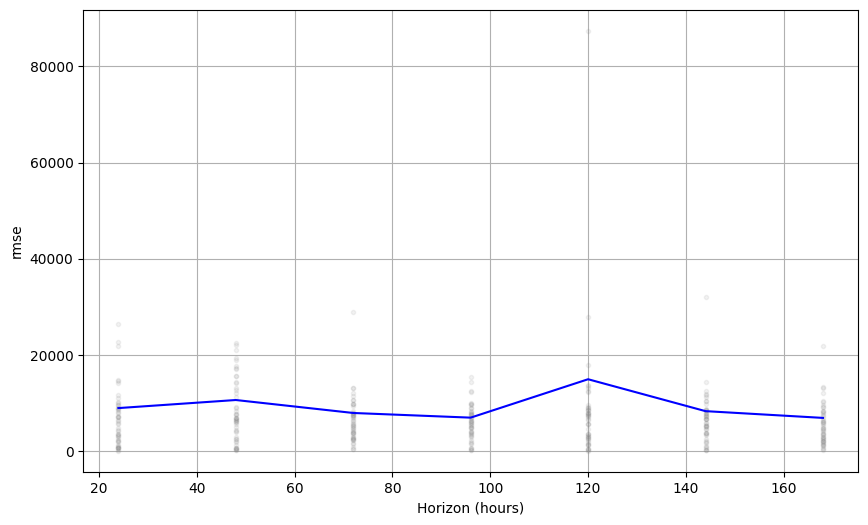

In [21]:
fig3 = plot_cross_validation_metric(cv_results, metric='rmse')

## 2) Prophet model with Holidays

In [22]:
df_calendar_event.rename(columns={'date': 'ds', 'event_name': 'holiday'}, inplace=True)
df_calendar_event = df_calendar_event[['holiday', 'ds']]

df_calendar_event['lower_window'] = 0
df_calendar_event['upper_window'] = 1


In [23]:
# model including holidays
prophet_model_holidays = Prophet(holidays=df_calendar_event)
prophet_model_holidays.fit(grouped_train_data)

# testing on test data
forecast_holidays = prophet_model_holidays.predict(grouped_test_data)

15:05:13 - cmdstanpy - INFO - Chain [1] start processing
15:05:14 - cmdstanpy - INFO - Chain [1] done processing


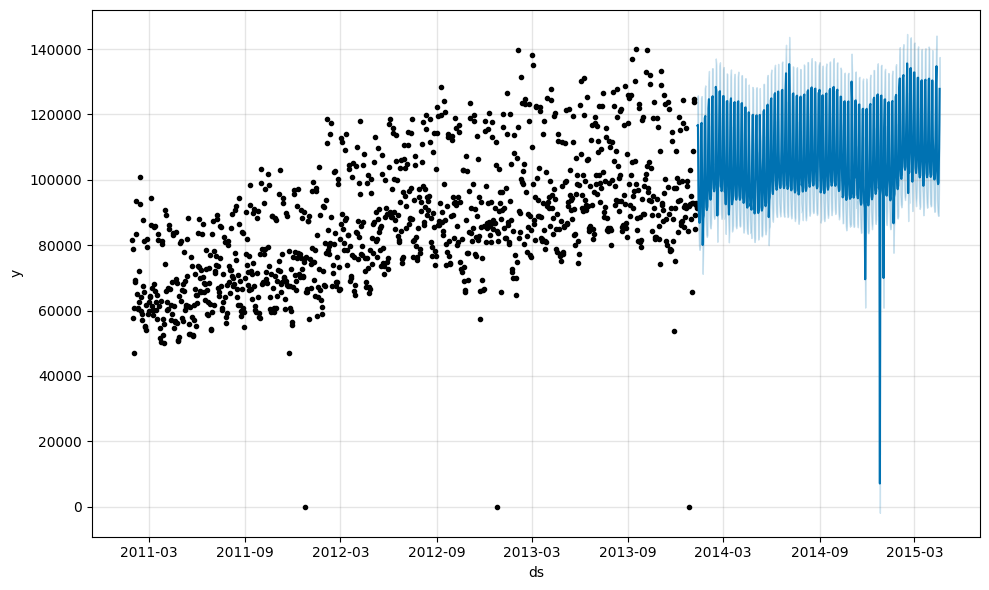

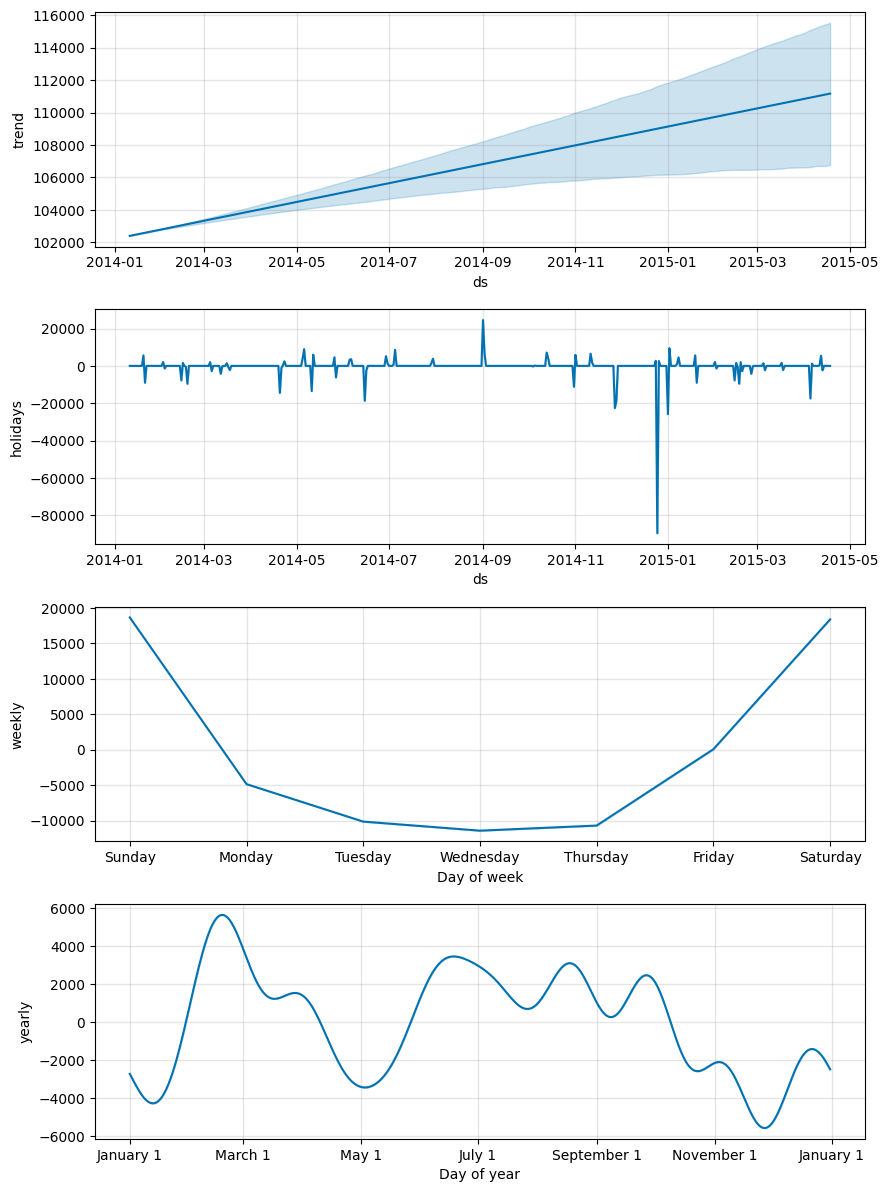

In [24]:
# visually evaluating the model perfromance

#Plot the forecast
prophet_model_holidays.plot(forecast_holidays)
plt.show()

# # Plot forecast components (trend, yearly, weekly seasonality)
prophet_model_holidays.plot_components(forecast_holidays)

plt.show()

### Cross Validation

In [25]:
cv_results_holidays = cross_validation(prophet_model_holidays, initial='730 days', period='7 days', horizon='7 days')

  0%|          | 0/49 [00:00<?, ?it/s]15:05:14 - cmdstanpy - INFO - Chain [1] start processing
15:05:14 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/49 [00:00<00:15,  3.17it/s]15:05:15 - cmdstanpy - INFO - Chain [1] start processing
15:05:15 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 2/49 [00:00<00:15,  3.04it/s]15:05:15 - cmdstanpy - INFO - Chain [1] start processing
15:05:15 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 3/49 [00:01<00:16,  2.84it/s]15:05:15 - cmdstanpy - INFO - Chain [1] start processing
15:05:15 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 4/49 [00:01<00:15,  2.89it/s]15:05:16 - cmdstanpy - INFO - Chain [1] start processing
15:05:16 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 5/49 [00:01<00:14,  2.97it/s]15:05:16 - cmdstanpy - INFO - Chain [1] start processing
15:05:16 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 6/49 [00:02<00:14,  2.98it/s]15:05:16

In [26]:
metrics_results = performance_metrics(cv_results_holidays)

metrics_results

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,8.678714e+07,9315.961516,6973.004597,0.058412,0.050609,0.058879,0.653061
1,2 days,9.832857e+07,9916.076507,7433.799593,0.062279,0.040158,0.062616,0.714286
2,3 days,4.444809e+07,6666.940028,5664.824175,0.060562,0.055902,0.059911,0.755102
3,4 days,4.396437e+07,6630.563274,5750.623641,0.066483,0.070007,0.065191,0.795918
4,5 days,6.199008e+07,7873.377961,6072.257833,0.351204,0.068987,0.109988,0.775510
5,6 days,4.678280e+07,6839.795663,5816.790235,0.069655,0.068576,0.067784,0.734694
6,7 days,3.689652e+07,6074.250693,5122.966812,0.052271,0.046477,0.051689,0.775510


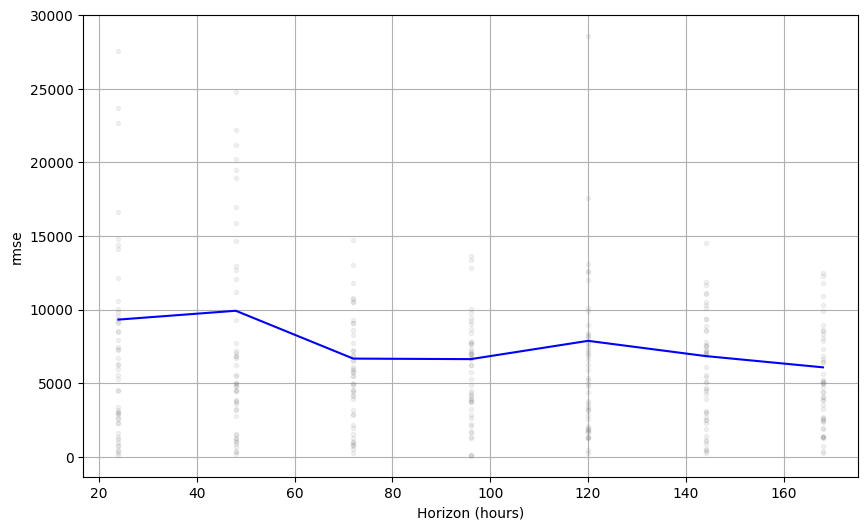

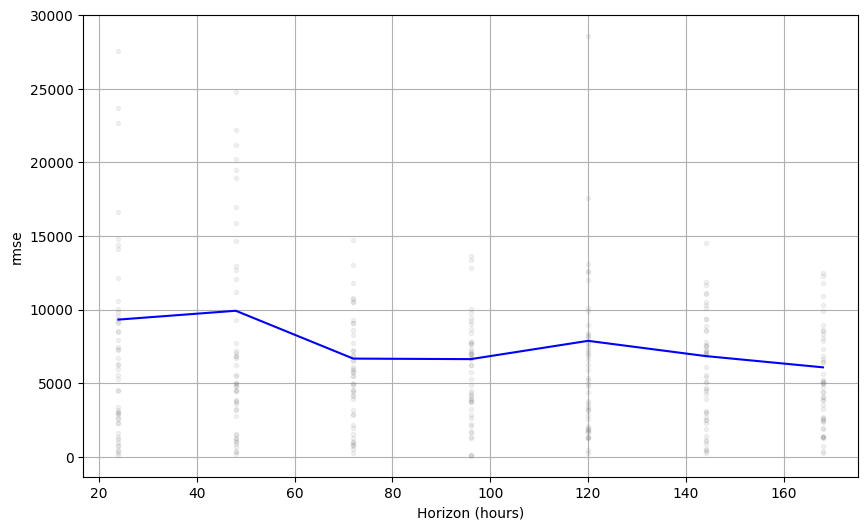

In [27]:
plot_cross_validation_metric(cv_results_holidays, metric='rmse')

In [28]:
from src.models.evaluation_metric import print_regressor_scores

print_regressor_scores(grouped_test_data['y'], forecast_holidays['yhat'], set_name="test")

RMSE test: 8974.667439542487
MAE test : 7201.4668096957475
R2 score test : 0.7624067989238424


In [29]:

# changepoints = df_calendar_event['ds']

## 3) Prophet model with seasonality only

In [30]:
# Introducing seasonality hyperparameter 
prophet_model_seasonality = Prophet(yearly_seasonality=True, weekly_seasonality=False)
prophet_model_seasonality.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# training the model
prophet_model_seasonality.fit(grouped_train_data)


forcast_seasonality = prophet_model_seasonality.predict(grouped_test_data)


15:05:31 - cmdstanpy - INFO - Chain [1] start processing
15:05:31 - cmdstanpy - INFO - Chain [1] done processing


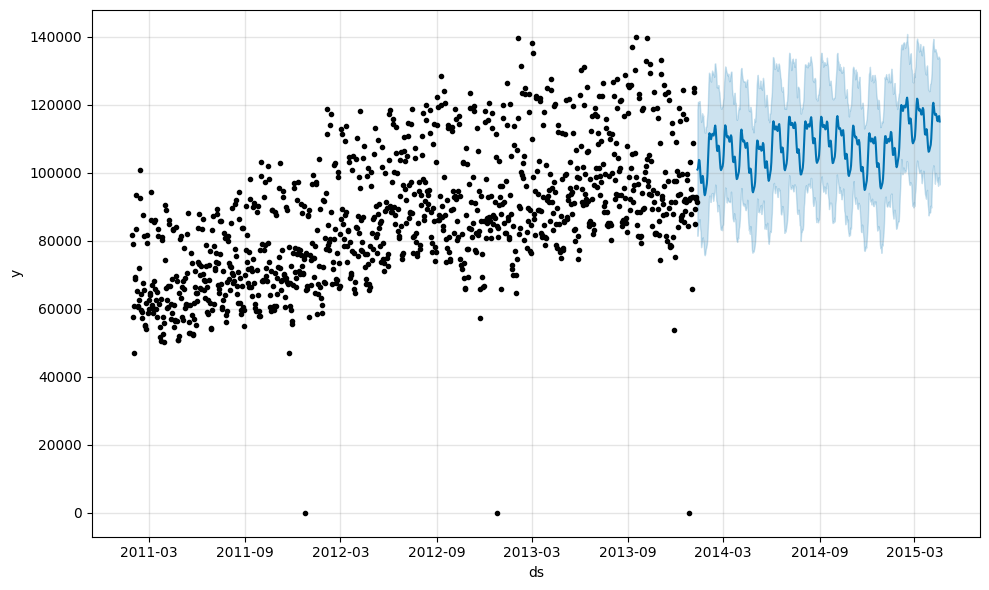

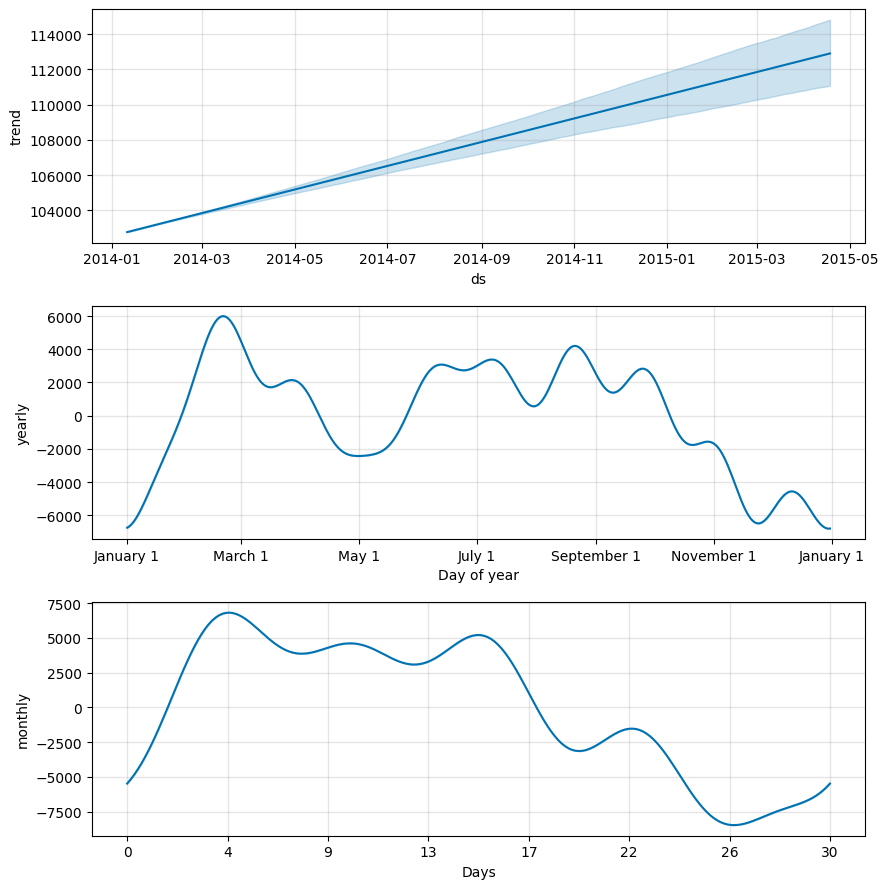

In [31]:
# Visaul evaluation

#Plot the forecast
prophet_model_seasonality.plot(forcast_seasonality)
plt.show()


# Plot forecast components (trend, yearly, weekly seasonality)
prophet_model_seasonality.plot_components(forcast_seasonality)
plt.show()

### Cross Validation

In [32]:
cv_results_seasonality = cross_validation(prophet_model_seasonality, initial='760 days', period='7 days', horizon='7 days')

  0%|          | 0/45 [00:00<?, ?it/s]15:05:32 - cmdstanpy - INFO - Chain [1] start processing
15:05:32 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/45 [00:00<00:07,  5.97it/s]15:05:32 - cmdstanpy - INFO - Chain [1] start processing
15:05:32 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 2/45 [00:00<00:07,  5.44it/s]15:05:32 - cmdstanpy - INFO - Chain [1] start processing
15:05:32 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/45 [00:00<00:08,  4.78it/s]15:05:32 - cmdstanpy - INFO - Chain [1] start processing
15:05:32 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/45 [00:00<00:10,  3.85it/s]15:05:33 - cmdstanpy - INFO - Chain [1] start processing
15:05:33 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 5/45 [00:01<00:10,  3.89it/s]15:05:33 - cmdstanpy - INFO - Chain [1] start processing
15:05:33 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 6/45 [00:01<00:09,  3.91it/s]15:05:33

In [33]:
metrics_results = performance_metrics(cv_results_seasonality)
metrics_results

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,4.286042e+08,20702.758010,19700.852946,0.163377,0.168357,0.179303,0.311111
1,2 days,4.814310e+08,21941.535078,20406.247582,0.166174,0.172609,0.183352,0.266667
2,3 days,5.637397e+07,7508.260044,6233.895254,0.066682,0.063184,0.064551,0.977778
3,4 days,1.571120e+08,12534.431095,11676.924877,0.134743,0.142016,0.124931,0.977778
4,5 days,4.025102e+08,20062.657491,15898.475059,59.124570,0.159570,0.194112,0.733333
5,6 days,2.109093e+08,14522.717325,13212.196091,0.160229,0.146279,0.144742,0.844444
6,7 days,3.194948e+07,5652.386906,4521.428636,0.046735,0.040426,0.046109,1.000000


In [34]:

# evaluation
print_regressor_scores( grouped_test_data['y'],forcast_seasonality['yhat'], set_name="test")

RMSE test: 17581.598981170795
MAE test : 15075.47866173148
R2 score test : 0.08816969995655843


## 4) Model with with seasonality and holiday

In [35]:
# seasonality with holiday
# introducing quaterly seasonality on the data
prophet_model_seasonality_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=df_calendar_event)
prophet_model_seasonality_holiday.add_seasonality(name='quarterly', period=30.5, fourier_order=5)
prophet_model_seasonality_holiday.fit(grouped_train_data)

# testing on the test day
forcast_seasonality_holiday = prophet_model_seasonality_holiday.predict(grouped_test_data)


15:05:43 - cmdstanpy - INFO - Chain [1] start processing
15:05:43 - cmdstanpy - INFO - Chain [1] done processing


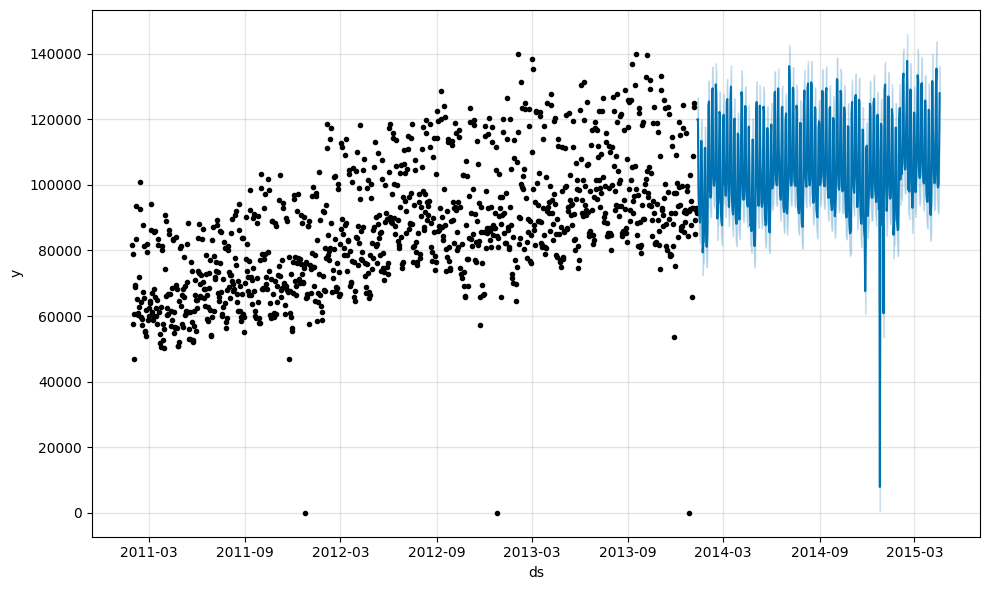

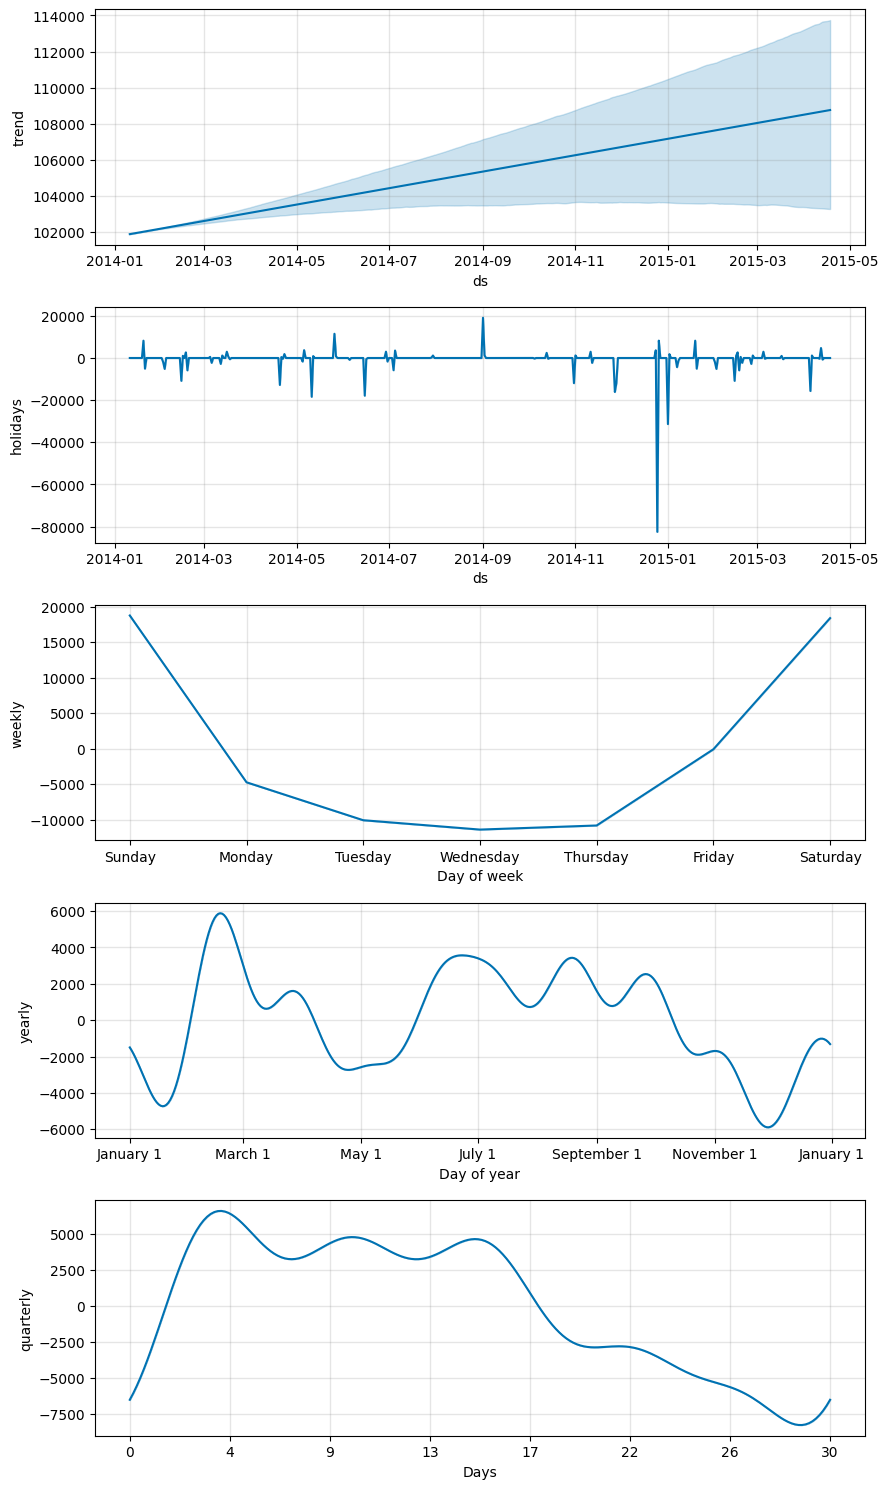

In [36]:
#Plot the forecast
prophet_model_seasonality_holiday.plot(forcast_seasonality_holiday)
plt.show()


# # Plot forecast components (trend, yearly, weekly seasonality)
prophet_model_seasonality_holiday.plot_components(forcast_seasonality_holiday)
plt.show()

### Cross Validation

In [37]:
cv_result_seaonality_holidays = cross_validation(prophet_model_seasonality_holiday, initial='730 days', period='7 days', horizon='7 days')
metrics_results = performance_metrics(cv_result_seaonality_holidays)
metrics_results

  0%|          | 0/49 [00:00<?, ?it/s]15:05:44 - cmdstanpy - INFO - Chain [1] start processing
15:05:44 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/49 [00:00<00:15,  3.03it/s]15:05:44 - cmdstanpy - INFO - Chain [1] start processing
15:05:44 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 2/49 [00:00<00:15,  3.04it/s]15:05:45 - cmdstanpy - INFO - Chain [1] start processing
15:05:45 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 3/49 [00:00<00:14,  3.16it/s]15:05:45 - cmdstanpy - INFO - Chain [1] start processing
15:05:45 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 4/49 [00:01<00:14,  3.12it/s]15:05:45 - cmdstanpy - INFO - Chain [1] start processing
15:05:45 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 5/49 [00:01<00:14,  3.07it/s]15:05:46 - cmdstanpy - INFO - Chain [1] start processing
15:05:46 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 6/49 [00:01<00:13,  3.08it/s]15:05:46

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,5.919699e+07,7693.957950,5752.282451,0.048302,0.037919,0.048662,0.693878
1,2 days,6.539020e+07,8086.420907,6427.783745,0.053962,0.047127,0.054465,0.551020
2,3 days,2.205699e+07,4696.487289,3721.601843,0.039771,0.036287,0.039205,0.836735
3,4 days,1.935945e+07,4399.937247,3696.906539,0.042475,0.037831,0.041834,0.836735
4,5 days,3.932105e+07,6270.650046,4420.153348,0.261436,0.043223,0.091321,0.795918
5,6 days,2.510254e+07,5010.243896,3790.310304,0.045597,0.031837,0.044242,0.775510
6,7 days,3.238211e+07,5690.528170,4486.847680,0.045372,0.036934,0.045359,0.775510


In [38]:
# evaluation
print_regressor_scores( grouped_test_data['y'],forcast_seasonality_holiday['yhat'], set_name="test")

RMSE test: 7958.23951218679
MAE test : 6155.952623208749
R2 score test : 0.8131765916979633


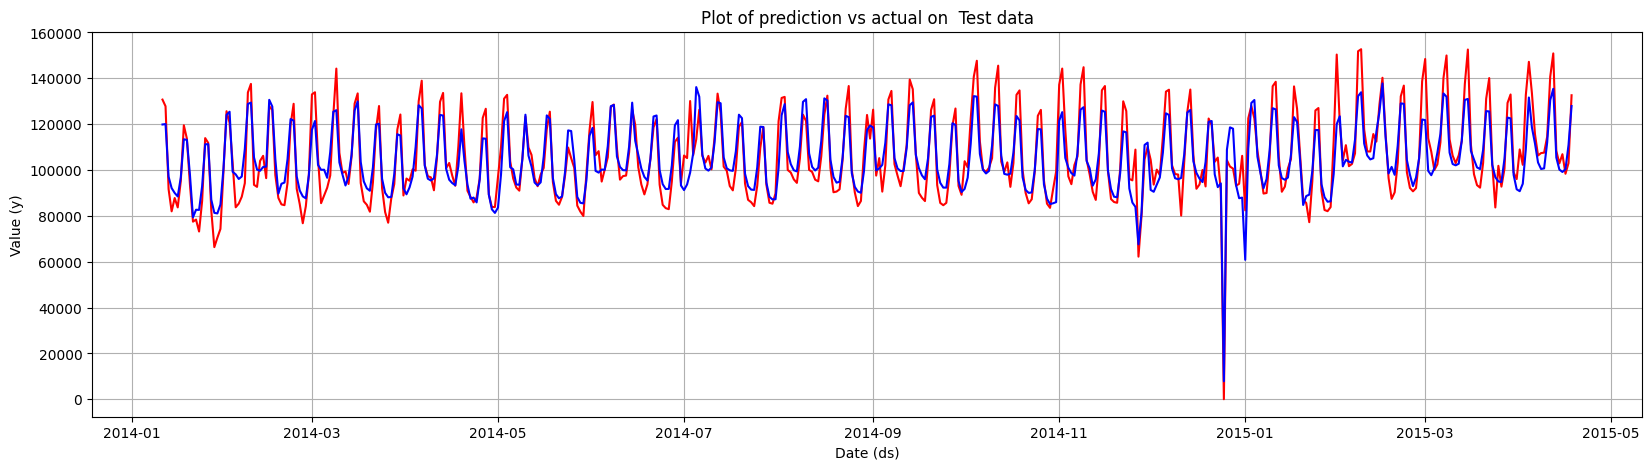

In [39]:
## ploting the total sales against the datestamp for training data

# Plotting
plt.figure(figsize=(20,5))
plt.plot(grouped_test_data['ds'], grouped_test_data['y'], linestyle='-', color='r')
plt.plot(forcast_seasonality_holiday['ds'], forcast_seasonality_holiday['yhat'], linestyle='-', color='b')

# Add labels and title
plt.xlabel('Date (ds)')
plt.ylabel('Value (y)')
plt.title('Plot of prediction vs actual on  Test data')
plt.grid(True)

# Show the plot
plt.show()

Remarks:
- The hyperparameter tuned Prophet with seasonality along with the knowledge of holiday has RMSE and MAE score smaller comparing to its previous version
- As seen in the plot it has been able to find the spike on end month of 2014 around December
- The model has good forecast for next 6 months after which the confidence interval gets wider.
- These hyperparamter, seasonality and holiday features has contributed to forecast.


The model with the defined parameters are able to detect seasonality and effects of holidays. Therefore building final model would based on the above hyperparameters training on all the data.

# Final Model 

## Training Prophet on all data except upcomming 7 days

In [40]:
grouped_df = pd.concat([grouped_train_data, grouped_test_data], axis=0).reset_index(drop=True)


In [41]:
grouped_df.head()

,ds,y
0,2011-01-29,81649.953125
1,2011-01-30,78969.398438
2,2011-01-31,57706.687500
3,2011-02-01,60760.929688
4,2011-02-02,46959.585938


In [42]:
grouped_df.tail(7)

,ds,y
1534,2015-04-12,150876.375000
1535,2015-04-13,108344.179688
1536,2015-04-14,102896.460938
1537,2015-04-15,106912.578125
1538,2015-04-16,98372.804688
1539,2015-04-17,103030.078125
1540,2015-04-18,132624.703125


In [57]:
# splitting the train data from whole data
grouped_df_train = grouped_df[grouped_df['ds']<'2015-04-12']
grouped_df_test = grouped_df[grouped_df['ds']>='2015-04-12']

In [58]:
final_prophet_model_seasonality_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=df_calendar_event)
final_prophet_model_seasonality_holiday.add_seasonality(name='quarterly', period=30.5, fourier_order=5)
final_prophet_model_seasonality_holiday.fit(grouped_df_train)


# creating 7 days future days from 2015-04-12
future_dates = final_prophet_model_seasonality_holiday.make_future_dataframe(periods=7)

# testing on the test day
final_forcast_seasonality_holiday = final_prophet_model_seasonality_holiday.predict(future_dates)


15:16:39 - cmdstanpy - INFO - Chain [1] start processing
15:16:40 - cmdstanpy - INFO - Chain [1] done processing


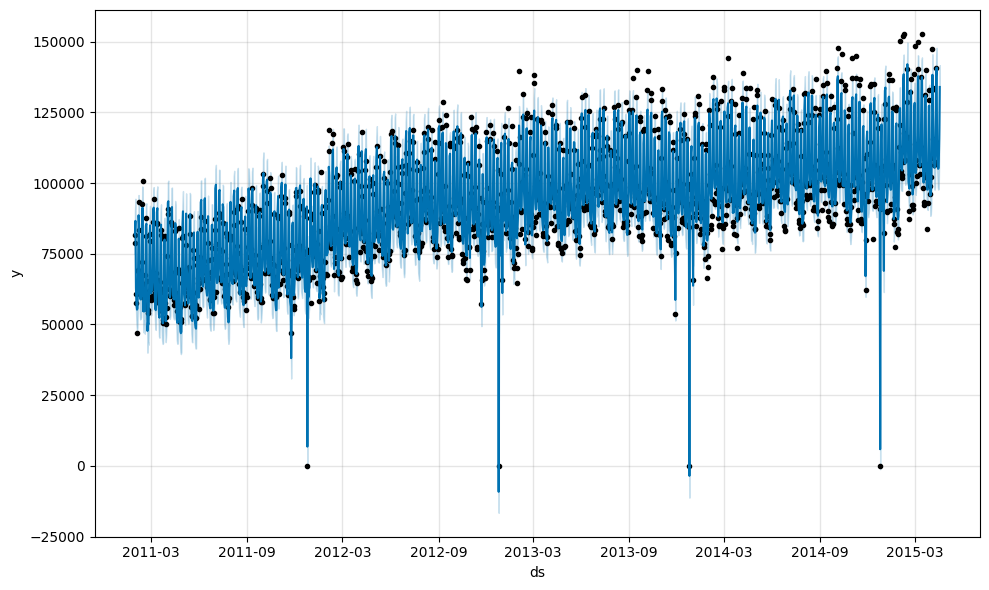

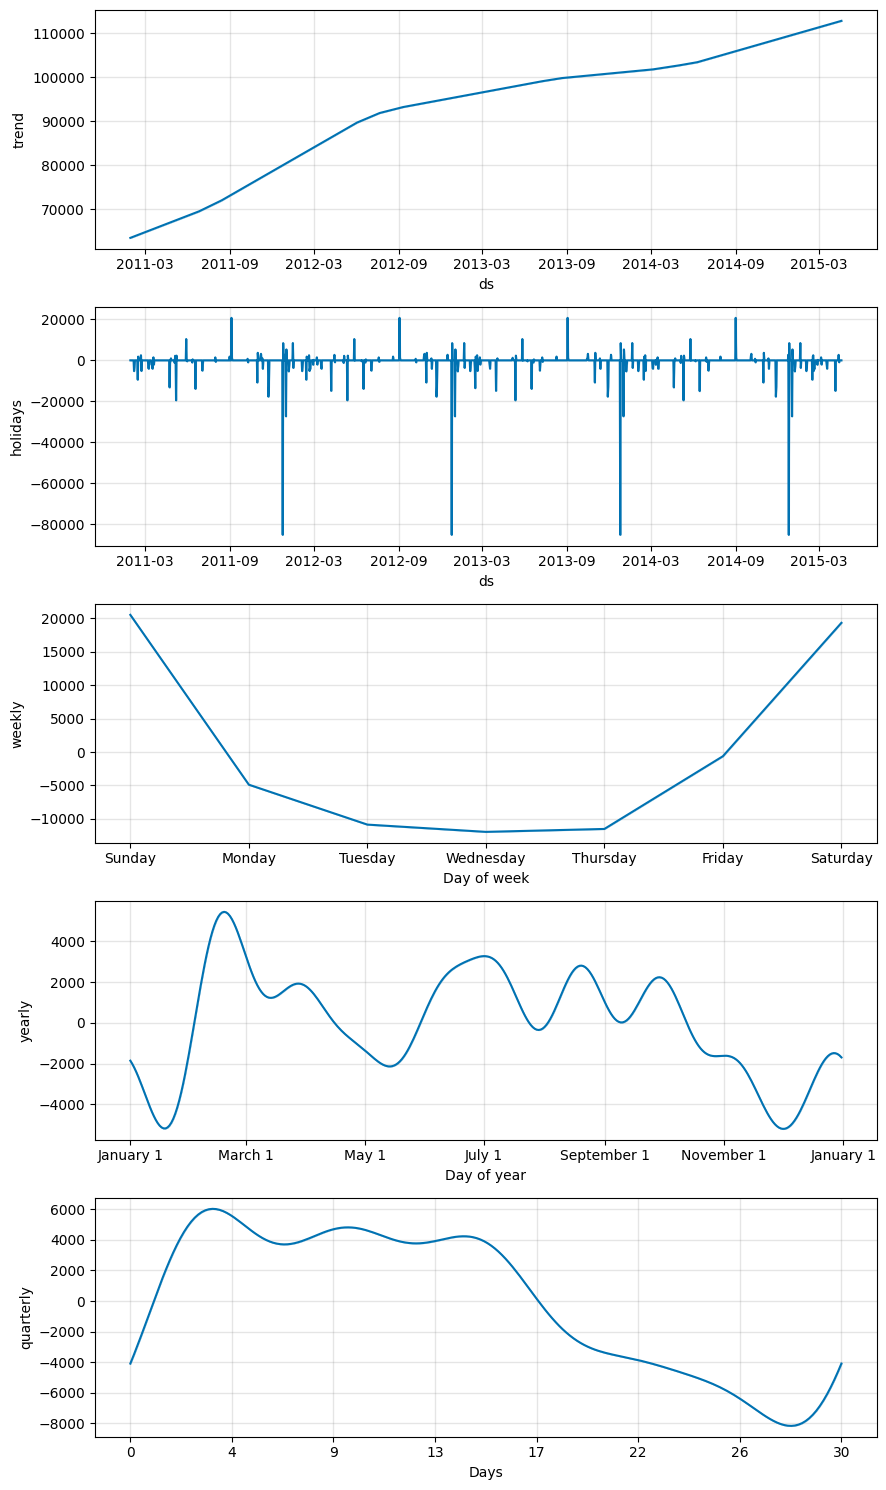

In [59]:
#Plot the forecast
final_prophet_model_seasonality_holiday.plot(final_forcast_seasonality_holiday)
plt.show()


# # Plot forecast components (trend, yearly, weekly seasonality)
final_prophet_model_seasonality_holiday.plot_components(final_forcast_seasonality_holiday)
plt.show()

### Cross Validation


In [60]:
cv_result_seaonality_holidays = cross_validation(final_prophet_model_seasonality_holiday, initial='1460 days', period='7 days', horizon='7 days')
metrics_results = performance_metrics(cv_result_seaonality_holidays)
metrics_results

  0%|          | 0/10 [00:00<?, ?it/s]15:16:45 - cmdstanpy - INFO - Chain [1] start processing
15:16:46 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 1/10 [00:00<00:03,  2.33it/s]15:16:46 - cmdstanpy - INFO - Chain [1] start processing
15:16:46 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:00<00:03,  2.30it/s]15:16:46 - cmdstanpy - INFO - Chain [1] start processing
15:16:46 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 3/10 [00:01<00:03,  2.28it/s]15:16:47 - cmdstanpy - INFO - Chain [1] start processing
15:16:47 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:01<00:02,  2.28it/s]15:16:47 - cmdstanpy - INFO - Chain [1] start processing
15:16:47 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 5/10 [00:02<00:02,  2.35it/s]15:16:48 - cmdstanpy - INFO - Chain [1] start processing
15:16:48 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 6/10 [00:02<00:01,  2.24it/s]15:16:48

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,1.492778e+08,12217.929487,10777.587245,0.075117,0.077604,0.078515,0.4
1,2 days,1.835697e+07,4284.503722,3205.817214,0.029364,0.019600,0.029610,0.9
2,3 days,4.213029e+07,6490.785073,4919.145126,0.051932,0.050527,0.050166,0.8
3,4 days,5.687522e+07,7541.566265,6033.765301,0.061878,0.046604,0.061018,0.7
4,5 days,4.126213e+07,6423.560346,5352.931084,0.054604,0.051964,0.053240,0.6
5,6 days,6.932976e+07,8326.449367,6748.622019,0.059813,0.059355,0.059526,0.6
6,7 days,6.528131e+07,8079.685302,5721.230709,0.039935,0.026537,0.041554,0.7


In [61]:
print_regressor_scores( grouped_df_test['y'],final_forcast_seasonality_holiday.tail(7)['yhat'], set_name="test")

RMSE test: 6918.265345686407
MAE test : 5564.103284359789
R2 score test : 0.85261122806655


Remarks:
- The model has been able to pick all the spike in sales occured during festivals and events
- The trend is smooth and is easily able to forecast the sales of upcomming 7 days with MaPE score less than 0 

## Saving the Final Model

In [62]:
import pickle
# Save the model using pickle
with open("../../models/forecasting/prophet_forecast_seasonality_holiday.pkl", 'wb') as file:
    pickle.dump(final_prophet_model_seasonality_holiday, file)
